In [1]:
import nbsetup
import numpy as np
import seaborn as sns
import pandas as pd
import ergodicpy as ep
import matplotlib.pyplot as plt

SAVE_FIGURES = False

# Code for plotting the results

Actual results below.

In [38]:
def plot(data, ax):
    # plot lines    
    g = sns.lineplot(data=pd.DataFrame(data).melt(id_vars=['observations', 'trial','noise']),
                     x='observations', y='value', hue='variable', palette='icefire', ax=ax)

    # settings reasonable height limits to give scale
    lims = ax.get_ylim()
    lower = min(lims[0], -0.01)
    upper = lims[1] if lims[1] > 1.0 else 1.0
    ax.set(ylim=(lower, upper))
    
    # adding a red zone where it's considered to be ignored
    bound = 0.1
    red_lower = lims[0] if lims[0] > -bound else -bound
    red_lower = 0.0 if red_lower > 0.0 else red_lower
    ax.axhspan(red_lower, bound, color='seashell')
    
    # adding a zero line for reference
    ax.axhline(y=0, color='grey', linestyle='dotted')
    

def generate(y_func, obs_range, noise=None, trials=1):
    data, ecs = [], []
    
    # generate data
    for o in obs_range:
        nbsetup.cp(o)
        for t in range(trials):
            x = np.random.random(o)
            
            # generate y incl noise
            y = y_func(x, o)
            if noise is not None:
                y = y + np.random.normal(0, noise, len(y))
            
            # generate metrics
            ec = ep.ErgodicCorrelation(x, y)
            mt = ec.correlations
            mt['observations'] = o
            mt['trial'] = t
            mt['noise'] = 0 if noise is None else noise
            
            tau2, tau2_p = ep.tau2(ec.complexity, len(ec.bins)-1)
            #mt['tau2'] = tau2
            mt['tau_p'] = tau2_p
            data.append(mt)
            ecs.append(ec)
    
    return data, ecs
    
    
def analyse(y_func, noise=None, obs_range=range(50,2000,50), name=None, trials=1):
    data, ecs = generate(y_func, obs_range, noise, trials)
    
    # plots
    fig, axes = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(15,5))
    
    # plot scatters
    f = sns.scatterplot(x=ecs[0].x, y=ecs[0].y, ax=axes[0])
    f.set_title("%s observations" % obs_range[0])
    l = sns.scatterplot(x=ecs[-1].x, y=ecs[-1].y, ax=axes[2])
    l.set_title("%s observations" % obs_range[-1])
    
    # plot measures
    plot(data, axes[1])
    
    if name is not None and SAVE_FIGURES:
        fig.savefig("figures/%s.eps" % name)
    
    return fig
    
    
def singular(x, y, name=None):
    ec = ep.ErgodicCorrelation(x, y)
    
    # plot the data raw
    fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15,5))
    sns.scatterplot(x=x, y=y, ax=axes[0])
    
    # plot the lines in the same format
    df = pd.DataFrame([ec.correlations, ec.correlations])
    df['observations']=[0,1]
    plot(df, axes[1])
    
    if name is not None and SAVE_FIGURES:
        fig.savefig("figures/%s.eps" % name)
    
    return fig

# No correlations

In all cases when there is no correlation the metrics all tend to 0 and are certainly within the 0.1 bound.

Where we can see that when there are very few observations all metrics become volatile.

1950


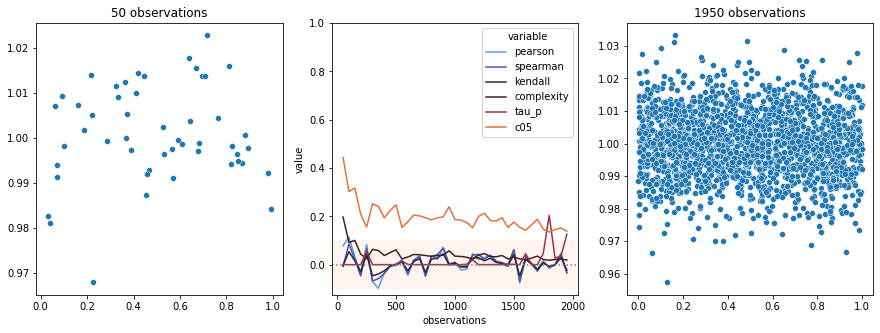

In [32]:
f = analyse(lambda x, o: np.ones(o), noise=0.01, name="flat")

1950


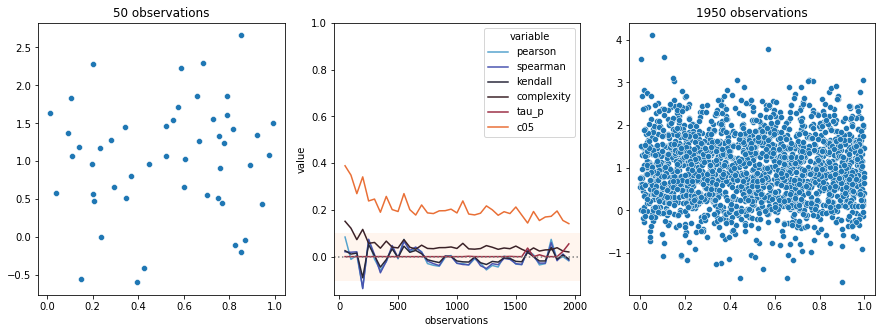

In [33]:
f = analyse(lambda x, o: np.ones(o), noise=0.8, name='flat-noisy')

1950


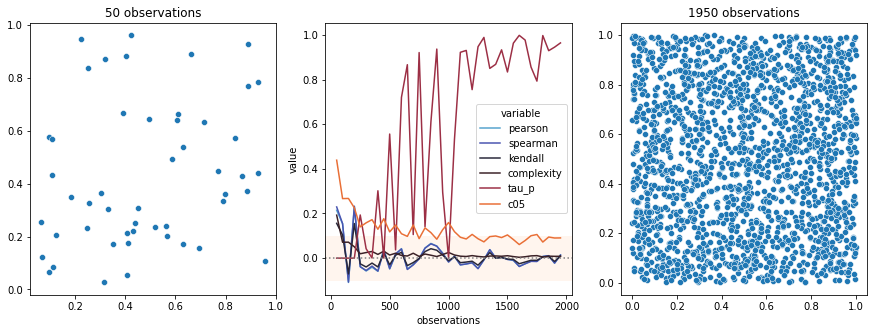

In [34]:
f = analyse(lambda x, o: np.random.random(o), name="random")

# A simple linear correlation

Now we start to see the metrics all shoot up high.

1950


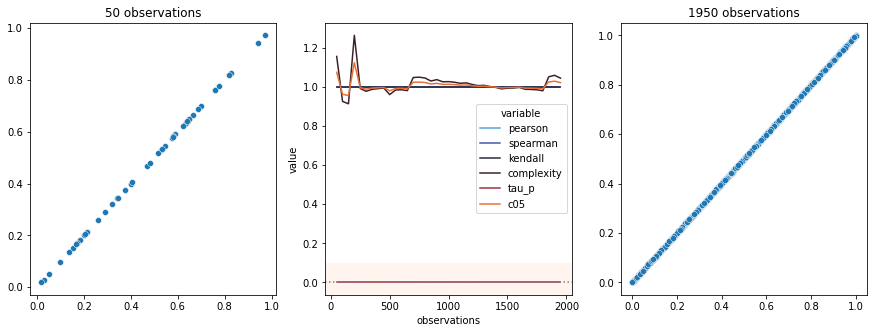

In [35]:
f = analyse(lambda x,o: x, name="linear")

# Noise

However, as we introduce noise into the system the PearsonR and SpearmanR metrics perform better.

1950


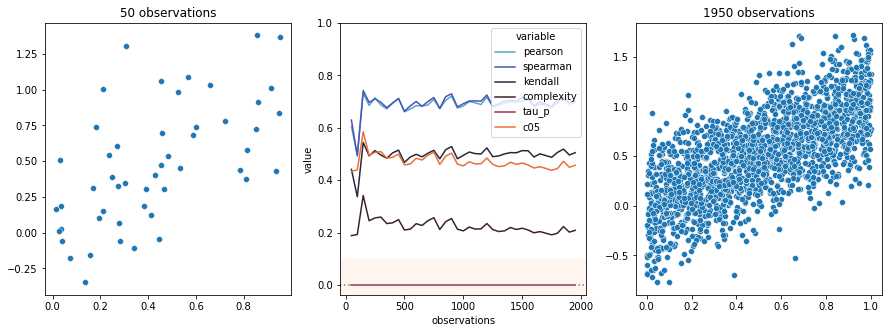

In [36]:
f = analyse(lambda x,o: x, noise=0.3, name="linear-noisy")

1950


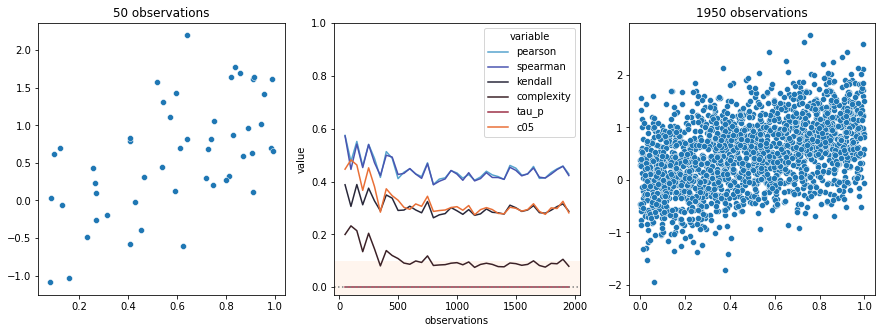

In [37]:
f = analyse((lambda x,o: x), noise=0.6, name="linear-very-noisy")

# Reverse

When the correlation is negative complexity picks this up, but does not reflect that the relationship is reversed. This is a feature which is utilised in it's power later.

Here the complexity metric does not give you an accurate measure of the correlation. Instead it's a compliment to encourage you to review the data in more detail and used as a compliment to PearsonR etc.

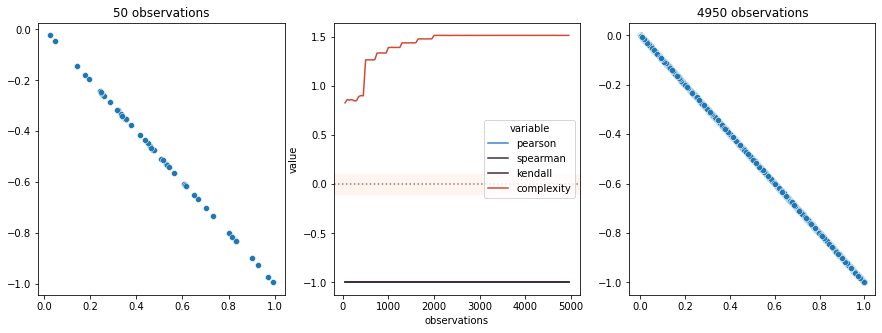

In [34]:
f = analyse(lambda x, o: -x, name="reverse-linear")

# More exotic shapes

4950


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


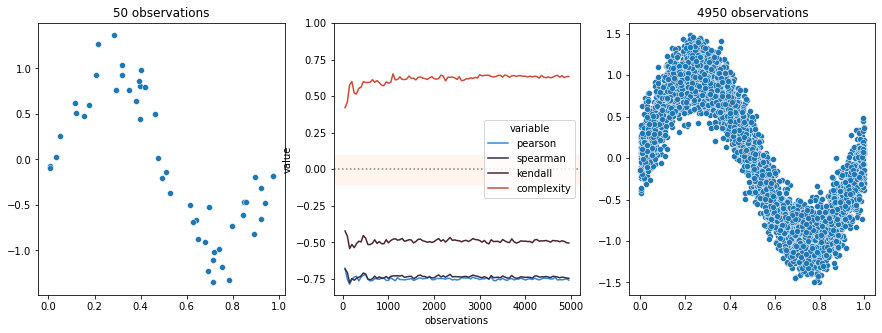

In [12]:
f = analyse(lambda x,o: np.sin(x*np.pi*2), noise=0.2, name="sin2pi")

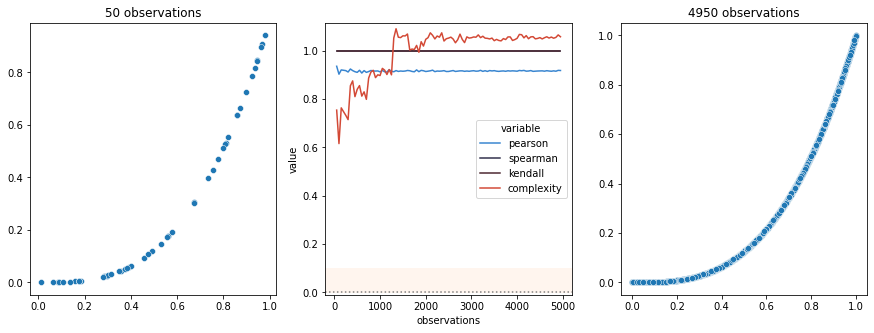

In [36]:
f = analyse(lambda x,o: x**3, name="power")

# Where ergodic complexity is uniquely placed

In the following examples we see the ergodic complexity measure finding an interesting relationship between the data where the other metrics fail.

4950


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


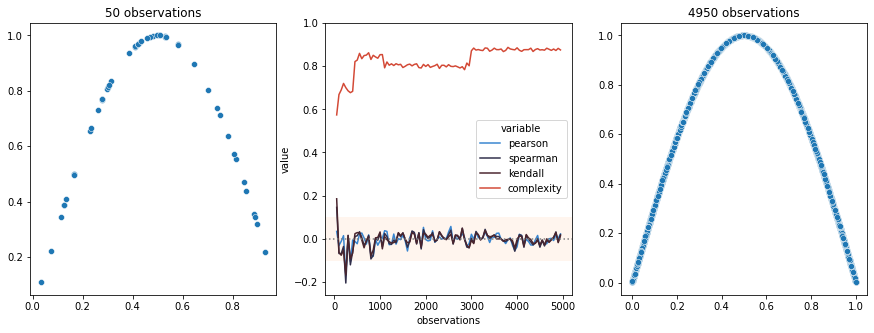

In [13]:
f = analyse(lambda x,o: np.sin(x*np.pi), name="sin-pi")

4950


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


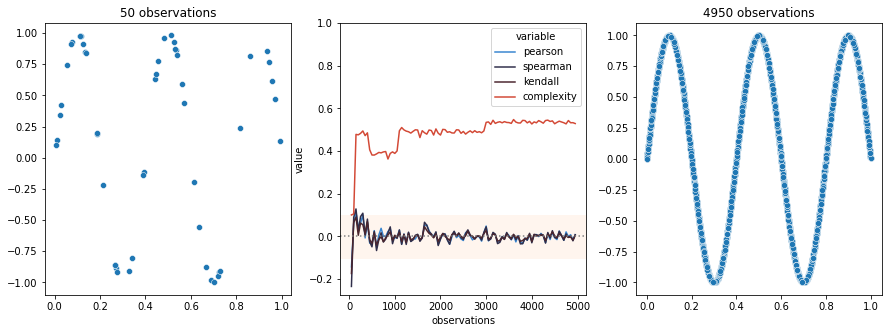

In [20]:
f = analyse(lambda x,o: np.sin(5*x*np.pi), name="sin5pi")

It's worth noting the level of noise impacts the absolute level of the ergodic complexity at the same rate irrelavent of relationship or shape of data (e.g. linear as above or sin as below).

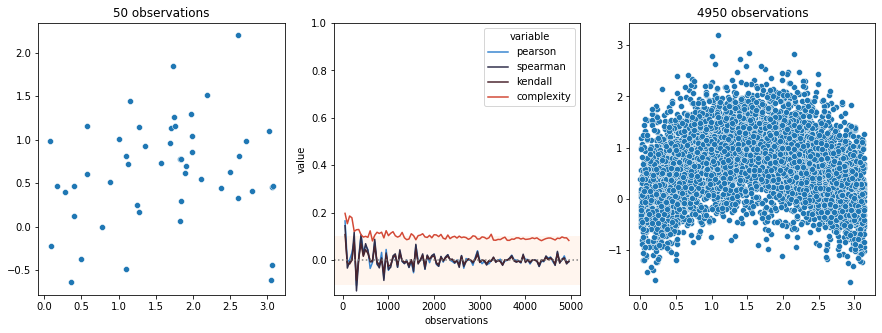

In [38]:
f = analyse(lambda x,o: np.sin(x), lambda o: np.random.random(o)*np.pi, noise=0.6, name="sin-pi-noisy")

# Specificly shaped models

In [39]:
try:
    funky = pd.read_csv("https://raw.githubusercontent.com/perlatex/R_for_Data_Science/master/demo_data/datasaurus.csv")
except:
    funky = pd.read_csv("../datasets/datasaurus.csv")

Baselining with 142 (the rough number of observations in each shape in the dataset) random observations. Shows that ergodic complexity does better at saying there's no relationship.

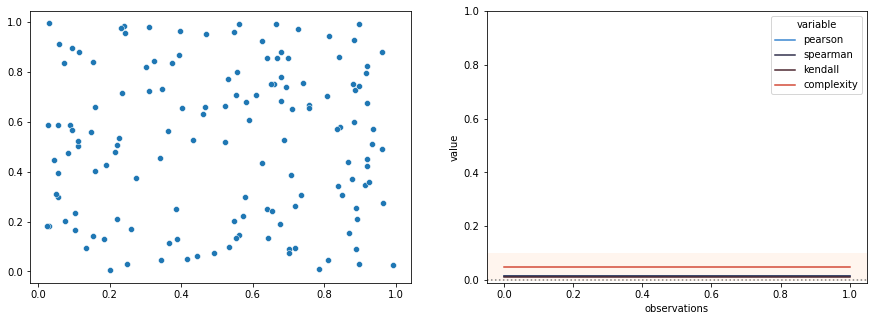

In [40]:
f = singular(np.random.random(142), np.random.random(142), name="single-random")

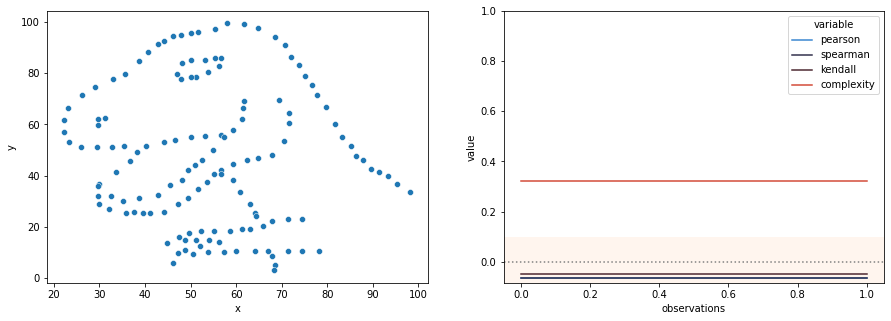

In [41]:
df = funky.loc[funky.dataset == 'dino']
f = singular(df['x'], df['y'], name="single-dino")

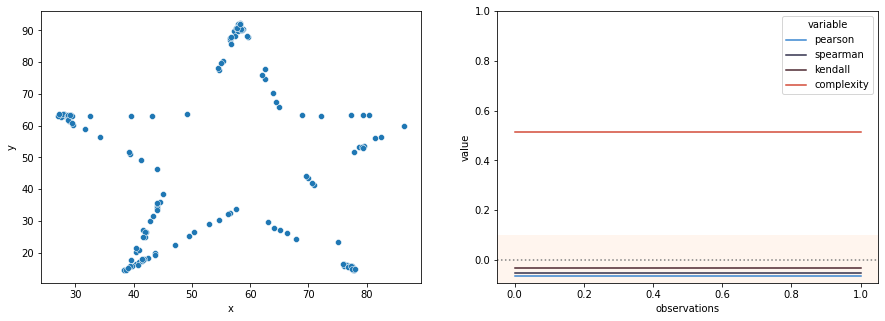

In [42]:
df = funky.loc[funky.dataset == 'star'].reset_index()
f = singular(df['x'], df['y'], name="single-star")

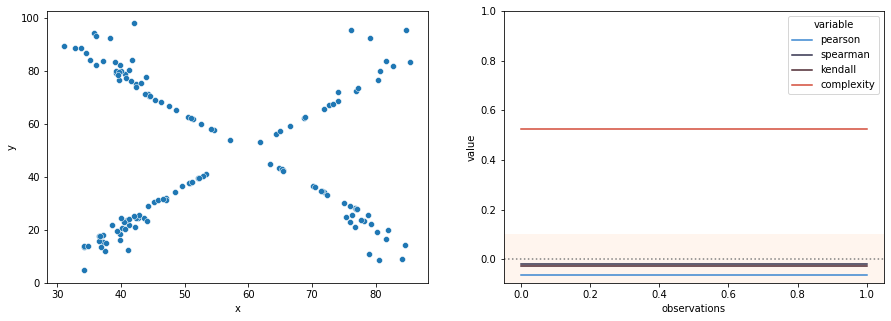

In [43]:
df = funky.loc[funky.dataset == 'x_shape'].reset_index()
f = singular(df['x'], df['y'], name="single-x")

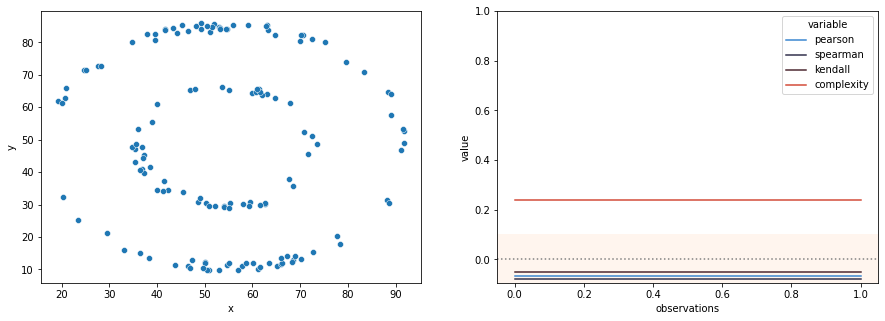

In [44]:
df = funky.loc[funky.dataset == 'bullseye'].reset_index()
f = singular(df['x'], df['y'], name="single-bullseye")

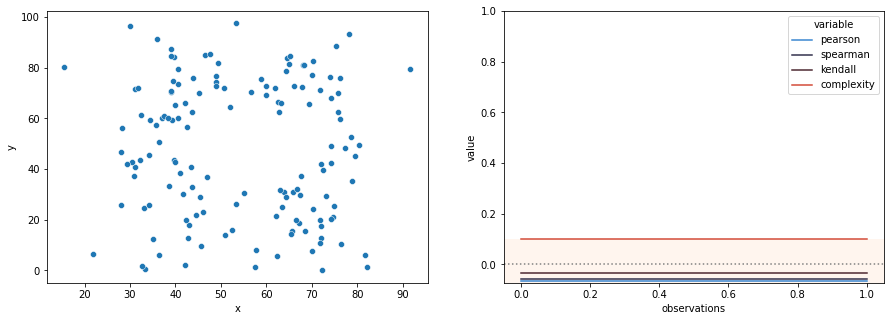

In [45]:
df = funky.loc[funky.dataset == 'away'].reset_index()
f = singular(df['x'], df['y'], name="single-away")

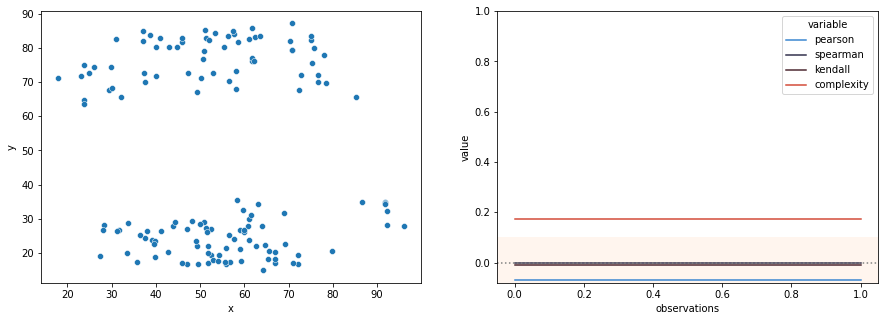

In [46]:
df = funky.loc[funky.dataset == 'high_lines'].reset_index()
f = singular(df['x'], df['y'], name="single-high")

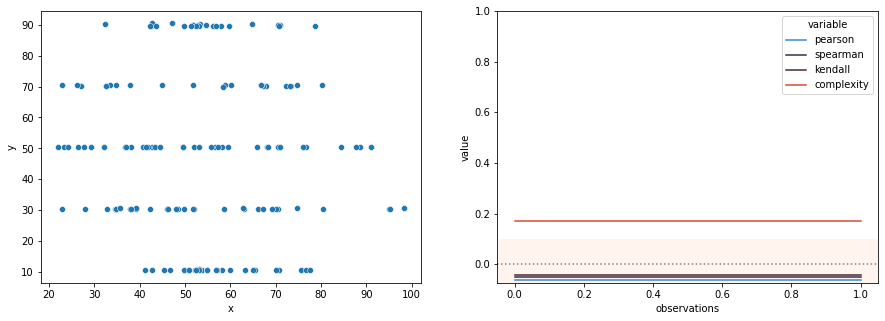

In [47]:
df = funky.loc[funky.dataset == 'h_lines'].reset_index()
f = singular(df['x'], df['y'], name="single-h")

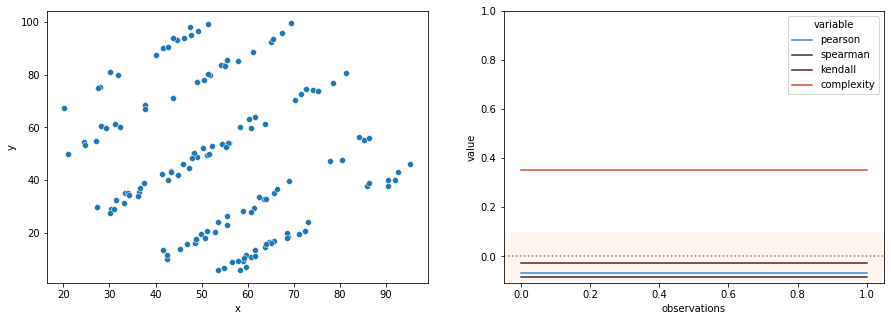

In [48]:
df = funky.loc[funky.dataset == 'slant_up'].reset_index()
f = singular(df['x'], df['y'], name="single-slant")

# The effect of noise

In [135]:
def regress(x, y):
    from sklearn.linear_model import LinearRegression
    m = LinearRegression().fit(x.to_numpy().reshape(-1,1), y)
    return (m.coef_, m.intercept_)

def noise_plot(y_func, noise=np.linspace(0.01, 1.0, 50), name=None):
    datasets = []
    for n in noise:
        data, ecs = generate(y_func, obs_range=[2000,3000], noise=n, trials=50)
        datasets = datasets + data
    
    # relationships
    fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15,5))
    df = pd.DataFrame(datasets)
    g = sns.lineplot(data=df.melt(id_vars=['observations', 'trial','noise']),
                         x='noise', y='value', hue='variable', palette='icefire', ax=axes[0])
    g.set_title('Metrics against noise')
    
    # regression
    df['y'] = (df['complexity']**-0.5)
    m, c = regress(df['noise'], df['y'])
    print(m, c)
    h = sns.lineplot(x=df['noise'], y=(df['y']-c)/m[0], ax=axes[1])
    h.set_title('Noise against (C^-0.5 -q)/m, q=%s, m=%s' % (c, m))
    h.set(ylim=(0,1))
    
    if SAVE_FIGURES:
        fig.savefig('figures/%s.eps' % name)
    return fig

3000
[3.99398955] 0.8774406423374814


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

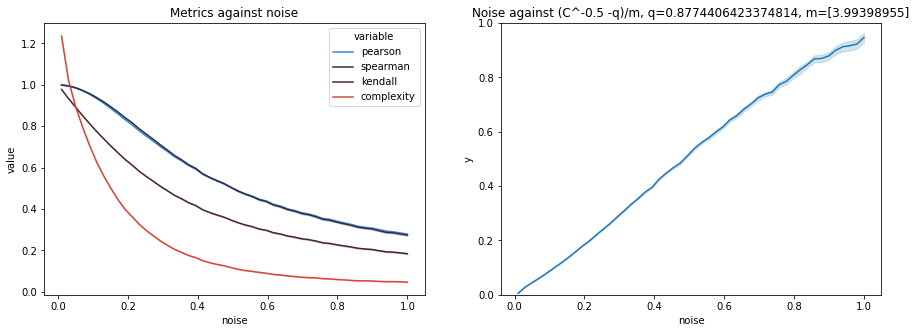

In [136]:
linear_noise = datasets = noise_plot(lambda x,o: x, name='noise-linear')

3000
[4.001669] 0.9534536479042424


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

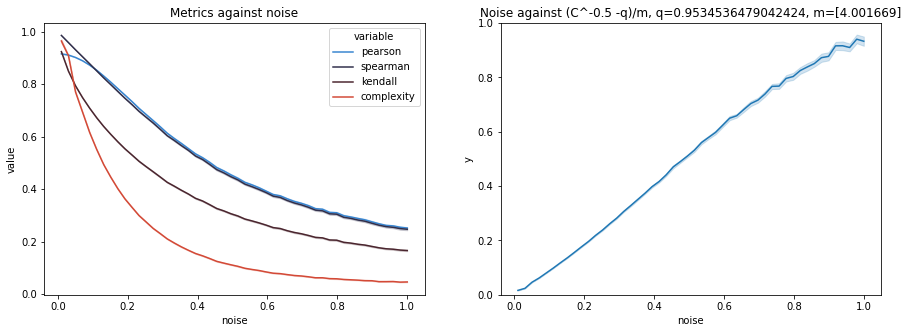

In [137]:
power_noise = noise_plot(lambda x,o: x**3, name='noise-power')

3000
[3.78992544] 0.9667631452848084


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

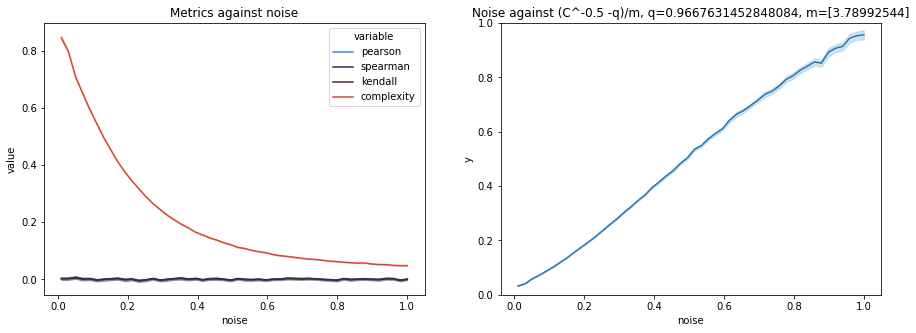

In [138]:
sin_noise = noise_plot(lambda x,o: np.sin(x*np.pi), name='noise-sin')